In [1]:
# imports / db pointers

from pymongo import MongoClient
from pprint import pprint
client = MongoClient("mongodb://takuu.dcs.gla.ac.uk:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = client.Game_data



In [2]:
# server status
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)


{'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 0, 'warning': 0},
 'connections': {'available': 810, 'current': 9, 'totalCreated': 4125},
 'extra_info': {'note': 'fields vary by platform', 'page_faults': 7},
 'globalLock': {'activeClients': {'readers': 0, 'total': 18, 'writers': 0},
                'currentQueue': {'readers': 0, 'total': 0, 'writers': 0},
                'totalTime': 2582246960000},
 'host': 'takuudcsglaacuk',
 'localTime': datetime.datetime(2020, 4, 8, 14, 56, 31, 164000),
 'locks': {'Collection': {'acquireCount': {'r': 5098017, 'w': 142268}},
           'Database': {'acquireCount': {'R': 70,
                                         'W': 8625,
                                         'r': 5098047,
                                         'w': 142267},
                        'acquireWaitCount': {'r': 1},
                        'timeAcquiringMicros': {'r': 40745}},
           'Global': {'acquireCount': {'W': 6, 'r': 12929403, 'w': 150892}}},
 'logicalSess

In [3]:
import re

# Parse the lookup tables
chars = ["K","A","W","R","H","M","B","G"]   # Order determined by lookup tables
pairs = []
for i in range(8):
    for j in range(i+1,8):
        pairs += [chars[i]+chars[j]]

lookup = {}        
        
        
for p in pairs:
    with open("lookup_tables/" + p + "_optimal_moves.txt","r") as f:
        single_pair_dict = {}
        for line in f.readlines()[2:]:
            state = re.split("\t+",line)[:-2]
            action = re.split("\t+",line)[-1][3:-1]
            if action in single_pair_dict.keys():
                single_pair_dict[action] += [state]
            else:
                single_pair_dict[action] = [state]
        lookup[p] = single_pair_dict
        print("finished: " + p)

finished: KA
finished: KW
finished: KR
finished: KH
finished: KM
finished: KB
finished: KG
finished: AW
finished: AR
finished: AH
finished: AM
finished: AB
finished: AG
finished: WR
finished: WH
finished: WM
finished: WB
finished: WG
finished: RH
finished: RM
finished: RB
finished: RG
finished: HM
finished: HB
finished: HG
finished: MB
finished: MG
finished: BG


In [4]:
import numpy as np

# read in the constants

KNIGHT_HEALTH = 10
KNIGHT_DAMAGE = 4
KNIGHT_ACCURACY = 60

ARCHER_HEALTH = 8
ARCHER_DAMAGE = 2
ARCHER_ACCURACY = 85

HEALER_HEALTH = 10
HEALER_DAMAGE = 2
HEALER_ACCURACY = 85
HEALER_HEAL = 1

ROGUE_HEALTH = 8
ROGUE_DAMAGE = 3
ROGUE_ACCURACY = 75
ROGUE_EXECUTE = 5

WIZARD_HEALTH = 8
WIZARD_DAMAGE = 2
WIZARD_ACCURACY = 85

MONK_HEALTH = 7
MONK_DAMAGE = 1
MONK_ACCURACY = 80

GUNNER_HEALTH = 8
GUNNER_DAMAGE = 4
GUNNER_MISS_DAMAGE = 1
GUNNER_ACCURACY = 75

BARBARIAN_HEALTH = 10
BARBARIAN_DAMAGE = 3
BARBARIAN_RAGE_DAMAGE = 5
BARBARIAN_RAGE_THRESHOLD = 4
BARBARIAN_ACCURACY = 75

def full_name(i):
    if i == "K": return "Knight"
    if i == "A": return "Archer"
    if i == "H": return "Healer"
    if i == "R": return "Rogue"
    if i == "W": return "Wizard"
    if i == "M": return "Monk"
    if i == "G": return "Gunner"
    if i == "B": return "Barbarian"
    print("full name called on unrecognised letter")

# Helper methods to build state and parse transitions
def set_health(char):
    if char == "Knight":
        return KNIGHT_HEALTH
    if char == "Archer":        
        return ARCHER_HEALTH
    if char == "Healer":        
        return HEALER_HEALTH
    if char == "Rogue":        
        return ROGUE_HEALTH
    if char == "Wizard":        
        return WIZARD_HEALTH
    if char == "Monk":        
        return MONK_HEALTH
    if char == "Gunner":        
        return GUNNER_HEALTH
    if char == "Barbarian":        
        return BARBARIAN_HEALTH
   

# Take an action string and state [], update the state
def do_action(action, state):
    
    if action[2] == "K":
        do_knight_action(action, state)
    if action[2] == "A":
        do_archer_action(action, state)
    if action[2] == "H":
        do_healer_action(action, state)
    if action[2] == "R":
        do_rogue_action(action, state)
    if action[2] == "W":
        do_wizard_action(action, state)
    if action[2] == "M":
        do_monk_action(action, state)
    if action[2] == "G":
        do_gunner_action(action, state)
    if action[2] == "B":
        do_barbarian_action(action, state)
    # Ensure min health is 0
    Is = [0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16]
    for i in Is:
        state[i] = max(0,state[i])
    # Reset stun
    if action[1] == "1":
        state[8] = "-"
    else:
        state[17] = "-"

def do_knight_action(action, state):
    # action e.g.: p1Kp2H_41
    roll = int(action.split("_")[1])
    if roll >= 100 - KNIGHT_ACCURACY:
        if action[1] == "1":
            state[9+chars.index(action[5])] -= KNIGHT_DAMAGE
        else:
            state[chars.index(action[5])] -= KNIGHT_DAMAGE
        
def do_archer_action(action, state):
    # action e.g.: p2Ap1K_55p1R_86 OR p2Ap1K_53
    roll1 = int(action.split("_")[1].split("p")[0])
    if roll1 >= 100 - ARCHER_ACCURACY:
        if action[1] == "1":
            state[9+chars.index(action[5])] -= ARCHER_DAMAGE
        else:
            state[chars.index(action[5])] -= ARCHER_DAMAGE
    # If there is no second target
    if len(action.split("_")) == 2:
        return
    roll2 = int(action.split("_")[2])
    target = action.split("_")[1][-1]
    if roll2 >= 100 - ARCHER_ACCURACY:
        if action[1] == "1":
            state[9+chars.index(target)] -= ARCHER_DAMAGE
        else:
            state[chars.index(target)] -= ARCHER_DAMAGE

def do_healer_action(action, state):
    # action e.g.: p2Hp1Rp2H_4
    roll = int(action.split("_")[1])
    if roll >= 100 - HEALER_ACCURACY:
        if len(action.split("p")) > 3:
            if action[1] == "1":
                state[9+chars.index(action[5])] -= HEALER_DAMAGE
                state[chars.index(action[8])] += HEALER_HEAL
                state[chars.index(action[8])] = min(
                    state[chars.index(action[8])], 
                    set_health(full_name(action[8]))
                )
            else:
                state[chars.index(action[5])] -= HEALER_DAMAGE
                state[9+chars.index(action[8])] += HEALER_HEAL
                state[9+chars.index(action[8])] = min(
                    state[9+chars.index(action[8])], 
                    set_health(full_name(action[8]))
                )
        else:
            if action[1] == "1":
                state[9+chars.index(action[5])] -= HEALER_DAMAGE
            else:
                state[chars.index(action[5])] -= HEALER_DAMAGE
            
def do_rogue_action(action, state):
    # action e.g.: p1Rp2H_53
    roll = int(action.split("_")[1])
    if roll >= 100 - KNIGHT_ACCURACY:
        if action[1] == "1":
            if state[9+chars.index(action[5])] <= ROGUE_EXECUTE:
                state[9+chars.index(action[5])] = 0
            else:
                state[9+chars.index(action[5])] -= ROGUE_DAMAGE
        else:
            if state[chars.index(action[5])] <= ROGUE_EXECUTE:
                state[chars.index(action[5])] = 0
            else:
                state[chars.index(action[5])] -= ROGUE_DAMAGE

def do_wizard_action(action, state):
    # action e.g.: p1Wp2W_13
    roll = int(action.split("_")[1])
    if roll >= 100 - WIZARD_ACCURACY:
        if action[1] == "1":
            state[9+chars.index(action[5])] -= WIZARD_DAMAGE
            state[17] = action[5]
        else:
            state[chars.index(action[5])] -= WIZARD_DAMAGE
            state[8] = action[5]

def do_monk_action(action, state):
    # etc
    roll = int(action.split("_")[1])
    if roll >= 100 - MONK_ACCURACY:
        if action[1] == "1":
            state[9+chars.index(action[5])] -= MONK_DAMAGE
        else:
            state[chars.index(action[5])] -= MONK_DAMAGE
            
def do_gunner_action(action, state):
    roll = int(action.split("_")[1])
    if roll >= 100 - GUNNER_ACCURACY:
        if action[1] == "1":
            state[9+chars.index(action[5])] -= GUNNER_DAMAGE
        else:
            state[chars.index(action[5])] -= GUNNER_DAMAGE
    else:
        if action[1] == "1":
            state[9+chars.index(action[5])] -= GUNNER_MISS_DAMAGE
        else:
            state[chars.index(action[5])] -= GUNNER_MISS_DAMAGE

def do_barbarian_action(action, state):
    roll = int(action.split("_")[1])
    if roll >= 100 - BARBARIAN_ACCURACY:
        if action[1] == "1":
            if state[chars.index("B")] <= BARBARIAN_RAGE_THRESHOLD:
                state[9+chars.index(action[5])] -= BARBARIAN_RAGE_DAMAGE
            else:
                state[9+chars.index(action[5])] -= BARBARIAN_DAMAGE
        else:
            if state[9+chars.index("B")] <= BARBARIAN_RAGE_THRESHOLD:
                state[chars.index(action[5])] -= BARBARIAN_RAGE_DAMAGE
            else:
                state[chars.index(action[5])] -= BARBARIAN_DAMAGE
            

In [5]:
# check if the move played was optimal
def move_lookup(state, move, pair):
    global corr, incorr, not_found
    lookup_state = [0]*11
    # get the state in the right form
    if move[1] == "1":
        lookup_state[0] = state[chars.index(pair[0])]
        lookup_state[1] = state[chars.index(pair[1])]
        lookup_state[2] = state[8]
        lookup_state[3:] = state[9:]
    else:
        lookup_state[0] = state[9+chars.index(pair[0])]
        lookup_state[1] = state[9+chars.index(pair[1])]
        lookup_state[2] = state[17]
        lookup_state[3:] = state[:9]
    
    # get the move in the right form
    move_notation = ""
    for letter in move:
        if letter in chars:
            move_notation += letter
        if len(move_notation) == 1:
            move_notation += "_"
    if len(move_notation) > 3 and move_notation[0] == "A":
        if chars.index(move_notation[2]) > chars.index(move_notation[3]):
            tmp = move_notation[:2] + move_notation[3] + move_notation[2]
            move_notation = tmp
    if "R_" in move_notation:
        if state[9+chars.index(move_notation[2])] <= ROGUE_EXECUTE:         # Check if move is a Rogue execute, if so append with e
            move_notation += "e"
    if "skip" in move:
        move_notation = move
    found = False
    tmp = []
    for letter in lookup_state:
        tmp += [str(letter)]
    lookup_state = tmp
    for k in lookup[pair].keys():
        if lookup_state in lookup[pair][k]:
            found = True
            if k == move_notation:
                #print("OPTIMAL MOVE PLAYED")
                corr+=1
            else:
                #print("MISTAKE:" + k + ", is the correct move")
                incorr+=1
    if not found:
        not_found += 1
        print("here", pair, lookup_state)


In [6]:
# open all games and calculates how many ...
      
count = 1                # .. games there are
malformed = 0            # malformed games there are
corr = 0                 # optimal moves are made
incorr = 0               # suboptimal moves are made
moves = 0                # total moves are made (should be sum of previous 2)
not_found = 0            # moves aren't found in the lookup tables (should be 0)

games = db.completed_games
for g in games.find():
    if not "p1c1" in g or not "p2c1" in g or len(g["Moves"]) < 2:
        malformed += 1
        continue
    #print("Game", str(count) + ":", g["p1c1"], g["p1c2"], "vs", g["p2c1"], g["p2c2"])
    team_1 = g["p1c1"][0] + g["p1c2"][0]
    if chars.index(team_1[0]) > chars.index(team_1[1]):
        team_1 = g["p1c2"][0] + g["p1c1"][0]
    
    team_2 = g["p2c1"][0] + g["p2c2"][0]
    if chars.index(team_2[0]) > chars.index(team_2[1]):
        team_2 = g["p2c2"][0] + g["p2c1"][0]
    state = [0]*8 + ["-"] + [0]*8 + ["-"]
    state[chars.index(g["p1c1"][0])] = set_health(g["p1c1"])
    state[chars.index(g["p1c2"][0])] = set_health(g["p1c2"])
    state[chars.index(g["p2c1"][0]) + 9] = set_health(g["p2c1"])
    state[chars.index(g["p2c2"][0]) + 9] = set_health(g["p2c2"])
    move = 1
    for m in g["Moves"]:
        moves+=1
        print("\tstate = " + str(state))
        print("\tmove " + str(move) + ": " + m)
        if m[1] == "1":
            r = move_lookup(state, m, team_1)
        else:
            r = move_lookup(state, m, team_2)
        do_action(m, state)
        move+=1
    #print("~~\n" + str(state)+"\n")
    count+=1
    
print("malformed:",malformed)
print("Games: " + str(count))
print("Moves: " + str(moves))
print("optimal: " + str(corr))
print("suboptimal: " + str(incorr))
print("not found: " + str(not_found))

	state = [10, 8, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 8, 0, 0, 0, 0, '-']
	move 1: p2Kp1A_73
	state = [10, 4, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 8, 0, 0, 0, 0, '-']
	move 2: p1Ap2K_21p2R_95
	state = [10, 4, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 6, 0, 0, 0, 0, '-']
	move 3: p2Rp1A_64
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 6, 0, 0, 0, 0, '-']
	move 4: p1Kp2R_77
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 2, 0, 0, 0, 0, '-']
	move 5: p2Kp1K_18
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 2, 0, 0, 0, 0, '-']
	move 6: p1Kp2R_66
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 0, 0, 0, 0, 0, '-']
	move 7: p2Kp1K_1
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 0, 0, 0, 0, 0, '-']
	move 8: p1Kp2K_33
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 0, 0, 0, 0, 0, '-']
	move 9: p2Kp1K_96
	state = [6, 0, 0, 0, 0, 0, 0, 0, '-', 8, 0, 0, 0, 0, 0, 0, 0, '-']
	move 10: p1Kp2K_55
	state = [6, 0, 0, 0, 0, 0, 0, 0, '-', 4, 0, 0, 0, 0, 0, 0, 0, '-']
	move 11: p2Kp1K_81
	state = [2, 0, 0, 0, 0, 

	state = [0, 0, 6, 4, 0, 0, 0, 0, '-', 4, 5, 0, 0, 0, 0, 0, 0, '-']
	move 12: p1Rp2K_37
	state = [0, 0, 0, 8, 10, 0, 0, 0, '-', 0, 0, 8, 8, 0, 0, 0, 0, '-']
	move 1: p2Rp1R_77
	state = [0, 0, 0, 5, 10, 0, 0, 0, '-', 0, 0, 8, 8, 0, 0, 0, 0, '-']
	move 2: p1Rp2W_60
	state = [0, 0, 0, 5, 10, 0, 0, 0, '-', 0, 0, 5, 8, 0, 0, 0, 0, '-']
	move 3: p2Rp1R_32
	state = [0, 0, 0, 5, 10, 0, 0, 0, '-', 0, 0, 5, 8, 0, 0, 0, 0, '-']
	move 4: p1Hp2W_77
	state = [0, 0, 0, 5, 10, 0, 0, 0, '-', 0, 0, 3, 8, 0, 0, 0, 0, '-']
	move 5: p2Wp1H_30
	state = [0, 0, 0, 5, 8, 0, 0, 0, 'H', 0, 0, 3, 8, 0, 0, 0, 0, '-']
	move 6: p1_skip
	state = [0, 0, 0, 5, 8, 0, 0, 0, '-', 0, 0, 3, 8, 0, 0, 0, 0, '-']
	move 7: p2Wp1H_24
	state = [0, 0, 0, 5, 6, 0, 0, 0, 'H', 0, 0, 3, 8, 0, 0, 0, 0, '-']
	move 8: p1_skip
	state = [0, 0, 0, 5, 6, 0, 0, 0, '-', 0, 0, 3, 8, 0, 0, 0, 0, '-']
	move 9: p2Wp1H_85
	state = [0, 0, 0, 5, 4, 0, 0, 0, 'H', 0, 0, 3, 8, 0, 0, 0, 0, '-']
	move 10: p1_skip
	state = [0, 0, 0, 5, 4, 0, 0, 0, '-', 0, 

	state = [0, 6, 0, 0, 10, 0, 0, 0, '-', 0, 6, 0, 0, 8, 0, 0, 0, '-']
	move 3: p2Ap1A_32p1H_22
	state = [0, 4, 0, 0, 8, 0, 0, 0, '-', 0, 6, 0, 0, 8, 0, 0, 0, '-']
	move 4: p1Hp2Ap1A_39
	state = [0, 5, 0, 0, 8, 0, 0, 0, '-', 0, 4, 0, 0, 8, 0, 0, 0, '-']
	move 5: p2Hp1Ap2A_7
	state = [0, 5, 0, 0, 8, 0, 0, 0, '-', 0, 4, 0, 0, 8, 0, 0, 0, '-']
	move 6: p1Ap2H_2p2A_24
	state = [0, 5, 0, 0, 8, 0, 0, 0, '-', 0, 2, 0, 0, 8, 0, 0, 0, '-']
	move 7: p2Hp1Ap2A_85
	state = [0, 3, 0, 0, 8, 0, 0, 0, '-', 0, 3, 0, 0, 8, 0, 0, 0, '-']
	move 8: p1Hp2Ap1A_39
	state = [0, 4, 0, 0, 8, 0, 0, 0, '-', 0, 1, 0, 0, 8, 0, 0, 0, '-']
	move 9: p2Hp1Ap2A_59
	state = [0, 2, 0, 0, 8, 0, 0, 0, '-', 0, 2, 0, 0, 8, 0, 0, 0, '-']
	move 10: p1Ap2H_88p2A_17
	state = [0, 2, 0, 0, 8, 0, 0, 0, '-', 0, 0, 0, 0, 6, 0, 0, 0, '-']
	move 11: p2Hp1Ap2H_24
	state = [0, 0, 0, 0, 8, 0, 0, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 12: p1Hp2Hp1H_70
	state = [0, 0, 0, 0, 9, 0, 0, 0, '-', 0, 0, 0, 0, 5, 0, 0, 0, '-']
	move 13: p2Hp1Hp2H_4

	state = [0, 6, 0, 0, 0, 0, 0, 0, '-', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 8: p2Wp1A_86
	state = [0, 4, 0, 0, 0, 0, 0, 0, 'A', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 9: p1_skip
	state = [0, 4, 0, 0, 0, 0, 0, 0, '-', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 10: p2Rp1A_96
	state = [0, 0, 8, 0, 0, 7, 0, 0, '-', 0, 0, 0, 8, 0, 0, 10, 0, '-']
	move 1: p2Bp1M_34
	state = [0, 0, 8, 0, 0, 4, 0, 0, '-', 0, 0, 0, 8, 0, 0, 10, 0, '-']
	move 2: p1Mp2R_90
	state = [0, 0, 8, 0, 0, 4, 0, 0, '-', 0, 0, 0, 7, 0, 0, 10, 0, '-']
	move 3: p1Mp2R_51
	state = [0, 0, 8, 0, 0, 4, 0, 0, '-', 0, 0, 0, 6, 0, 0, 10, 0, '-']
	move 4: p1Mp2R_2
	state = [0, 0, 8, 0, 0, 4, 0, 0, '-', 0, 0, 0, 6, 0, 0, 10, 0, '-']
	move 5: p2Rp1M_83
	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 0, 6, 0, 0, 10, 0, '-']
	move 6: p1Wp2R_60
	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 0, 4, 0, 0, 10, 0, 'R']
	move 7: p2Bp1W_43
	state = [0, 0, 5, 0, 0, 0, 0, 0, '-', 0, 0, 0, 4, 0, 0, 10, 0, '-']
	move 8: p1Wp2R_61
	state = [0, 0, 5, 0, 0, 0, 0, 0, '-'

	state = [10, 0, 0, 0, 0, 7, 0, 0, '-', 0, 0, 0, 8, 10, 0, 0, 0, '-']
	move 1: p2Rp1M_34
	state = [10, 0, 0, 0, 0, 7, 0, 0, '-', 0, 0, 0, 8, 10, 0, 0, 0, '-']
	move 2: p1Kp2R_87
	state = [10, 0, 0, 0, 0, 7, 0, 0, '-', 0, 0, 0, 4, 10, 0, 0, 0, '-']
	move 3: p2Rp1M_9
	state = [10, 0, 0, 0, 0, 7, 0, 0, '-', 0, 0, 0, 4, 10, 0, 0, 0, '-']
	move 4: p1Kp2R_87
	state = [10, 0, 0, 0, 0, 7, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 5: p2Hp1M_87
	state = [10, 0, 0, 0, 0, 5, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 6: p1Kp2H_50
	state = [10, 0, 0, 0, 0, 5, 0, 0, '-', 0, 0, 0, 0, 6, 0, 0, 0, '-']
	move 7: p2Hp1Mp2H_42
	state = [10, 0, 0, 0, 0, 3, 0, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 8: p1Kp2H_8
	state = [10, 0, 0, 0, 0, 3, 0, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 9: p2Hp1Kp2H_90
	state = [8, 0, 0, 0, 0, 3, 0, 0, '-', 0, 0, 0, 0, 8, 0, 0, 0, '-']
	move 10: p1Kp2H_89
	state = [8, 0, 0, 0, 0, 3, 0, 0, '-', 0, 0, 0, 0, 4, 0, 0, 0, '-']
	move 11: p2Hp1Kp2H_11
	state = [8, 0, 0, 

	state = [0, 0, 0, 0, 10, 0, 7, 0, '-', 7, 0, 0, 0, 0, 0, 10, 0, '-']
	move 3: p2Bp1B_48
	state = [0, 0, 0, 0, 10, 0, 4, 0, '-', 7, 0, 0, 0, 0, 0, 10, 0, '-']
	move 4: p1Bp2K_55
	state = [0, 0, 0, 0, 10, 0, 4, 0, '-', 2, 0, 0, 0, 0, 0, 10, 0, '-']
	move 5: p2Kp1B_30
	state = [0, 0, 0, 0, 10, 0, 4, 0, '-', 2, 0, 0, 0, 0, 0, 10, 0, '-']
	move 6: p1Bp2K_73
	state = [0, 0, 0, 0, 10, 0, 4, 0, '-', 0, 0, 0, 0, 0, 0, 10, 0, '-']
	move 7: p2Bp1B_2
	state = [0, 0, 0, 0, 10, 0, 4, 0, '-', 0, 0, 0, 0, 0, 0, 10, 0, '-']
	move 8: p1Bp2B_80
	state = [0, 0, 0, 0, 10, 0, 4, 0, '-', 0, 0, 0, 0, 0, 0, 5, 0, '-']
	move 9: p2Bp1B_98
	state = [0, 0, 0, 0, 10, 0, 1, 0, '-', 0, 0, 0, 0, 0, 0, 5, 0, '-']
	move 10: p1Bp2B_40
	state = [0, 0, 0, 8, 0, 0, 10, 0, '-', 0, 8, 0, 0, 10, 0, 0, 0, '-']
	move 1: p2Ap1B_28p1R_58
	state = [0, 0, 0, 6, 0, 0, 8, 0, '-', 0, 8, 0, 0, 10, 0, 0, 0, '-']
	move 2: p1Bp2A_40
	state = [0, 0, 0, 6, 0, 0, 8, 0, '-', 0, 5, 0, 0, 10, 0, 0, 0, '-']
	move 3: p2Ap1B_69p1R_53
	state = [0, 

	state = [0, 0, 0, 8, 0, 3, 0, 0, '-', 0, 6, 0, 0, 0, 0, 0, 0, '-']
	move 11: p1Mp2A_40
	state = [0, 0, 0, 8, 0, 3, 0, 0, '-', 0, 5, 0, 0, 0, 0, 0, 0, '-']
	move 12: p1Rp2A_84
	state = [0, 0, 8, 0, 10, 0, 0, 0, '-', 0, 8, 0, 8, 0, 0, 0, 0, '-']
	move 1: p2Rp1W_56
	state = [0, 0, 5, 0, 10, 0, 0, 0, '-', 0, 8, 0, 8, 0, 0, 0, 0, '-']
	move 2: p1Hp2Ap1W_95
	state = [0, 0, 6, 0, 10, 0, 0, 0, '-', 0, 6, 0, 8, 0, 0, 0, 0, '-']
	move 3: p2Rp1W_48
	state = [0, 0, 3, 0, 10, 0, 0, 0, '-', 0, 6, 0, 8, 0, 0, 0, 0, '-']
	move 4: p1Wp2R_71
	state = [0, 0, 3, 0, 10, 0, 0, 0, '-', 0, 6, 0, 6, 0, 0, 0, 0, 'R']
	move 5: p2Ap1W_62
	state = [0, 0, 1, 0, 10, 0, 0, 0, '-', 0, 6, 0, 6, 0, 0, 0, 0, '-']
	move 6: p1Wp2A_77
	state = [0, 0, 1, 0, 10, 0, 0, 0, '-', 0, 4, 0, 6, 0, 0, 0, 0, 'A']
	move 7: p2Rp1W_77
	state = [0, 0, 0, 0, 10, 0, 0, 0, '-', 0, 4, 0, 6, 0, 0, 0, 0, '-']
	move 8: p1Hp2R_18
	state = [0, 0, 0, 0, 10, 0, 0, 0, '-', 0, 4, 0, 4, 0, 0, 0, 0, '-']
	move 9: p2Ap1H_59
	state = [0, 0, 0, 0, 8, 0, 0

	state = [0, 0, 0, 0, 0, 0, 10, 5, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 5: p2Hp1G_52
	state = [0, 0, 0, 0, 0, 0, 10, 3, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 6: p1Gp2H_82
	state = [0, 0, 0, 0, 0, 0, 10, 3, '-', 0, 0, 0, 0, 6, 0, 0, 0, '-']
	move 7: p2Hp1Gp2H_20
	state = [0, 0, 0, 0, 0, 0, 10, 1, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 8: p1Gp2H_15
	state = [0, 0, 0, 0, 0, 0, 10, 1, '-', 0, 0, 0, 0, 6, 0, 0, 0, '-']
	move 9: p2Hp1Gp2H_39
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 10: p1Bp2H_23
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 11: p2Hp1Bp2H_89
	state = [0, 0, 0, 0, 0, 0, 8, 0, '-', 0, 0, 0, 0, 8, 0, 0, 0, '-']
	move 12: p1Bp2H_75
	state = [0, 0, 0, 0, 0, 0, 8, 0, '-', 0, 0, 0, 0, 5, 0, 0, 0, '-']
	move 13: p2Hp1Bp2H_40
	state = [0, 0, 0, 0, 0, 0, 6, 0, '-', 0, 0, 0, 0, 6, 0, 0, 0, '-']
	move 14: p1Bp2H_48
	state = [0, 0, 0, 0, 0, 0, 6, 0, '-', 0, 0, 0, 0, 3, 0, 0, 0, '-']
	move 15: p2Hp1Bp2H_22
	state = [0, 

	state = [10, 0, 0, 8, 0, 0, 0, 0, '-', 10, 0, 0, 8, 0, 0, 0, 0, '-']
	move 2: p2Rp1R_92
	state = [10, 0, 0, 5, 0, 0, 0, 0, '-', 10, 0, 0, 8, 0, 0, 0, 0, '-']
	move 3: p1Kp2R_70
	state = [10, 0, 0, 5, 0, 0, 0, 0, '-', 10, 0, 0, 4, 0, 0, 0, 0, '-']
	move 4: p2Rp1R_86
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 4, 0, 0, 0, 0, '-']
	move 5: p1Kp2R_44
	state = [10, 0, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 0, 0, 0, 0, 0, '-']
	move 6: p2Kp1K_90
	state = [6, 0, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 0, 0, 0, 0, 0, '-']
	move 7: p1Kp2K_10
	state = [6, 0, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 0, 0, 0, 0, 0, '-']
	move 8: p2Kp1K_49
	state = [2, 0, 0, 0, 0, 0, 0, 0, '-', 10, 0, 0, 0, 0, 0, 0, 0, '-']
	move 9: p1Kp2K_66
	state = [2, 0, 0, 0, 0, 0, 0, 0, '-', 6, 0, 0, 0, 0, 0, 0, 0, '-']
	move 10: p2Kp1K_92
	state = [10, 8, 0, 0, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 0, 0, 8, '-']
	move 1: p1Ap2G_67p2W_86
	state = [10, 8, 0, 0, 0, 0, 0, 0, '-', 0, 0, 6, 0, 0, 0, 0, 6, '-']
	move 2: p2Gp1A_62
	state = [10, 4, 0, 0

	state = [0, 0, 0, 5, 8, 0, 0, 0, '-', 0, 6, 0, 0, 0, 0, 0, 5, '-']
	move 6: p2Ap1R_97p1H_30
	state = [0, 0, 0, 3, 6, 0, 0, 0, '-', 0, 6, 0, 0, 0, 0, 0, 5, '-']
	move 7: p1Hp2Ap1R_92
	state = [0, 0, 0, 4, 6, 0, 0, 0, '-', 0, 4, 0, 0, 0, 0, 0, 5, '-']
	move 8: p2Ap1R_98p1H_5
	state = [0, 0, 0, 2, 6, 0, 0, 0, '-', 0, 4, 0, 0, 0, 0, 0, 5, '-']
	move 9: p1Rp2A_84
	state = [0, 0, 0, 0, 10, 0, 0, 8, '-', 0, 0, 0, 0, 0, 7, 0, 8, '-']
	move 1: p1Gp2G_1
	state = [0, 0, 0, 0, 10, 0, 0, 8, '-', 0, 0, 0, 0, 0, 7, 0, 7, '-']
	move 2: p2Mp1G_39
	state = [0, 0, 0, 0, 10, 0, 0, 7, '-', 0, 0, 0, 0, 0, 7, 0, 7, '-']
	move 3: p2Gp1G_78
	state = [0, 0, 0, 0, 10, 0, 0, 3, '-', 0, 0, 0, 0, 0, 7, 0, 7, '-']
	move 4: p1Gp2M_21
	state = [0, 0, 0, 0, 10, 0, 0, 3, '-', 0, 0, 0, 0, 0, 6, 0, 7, '-']
	move 5: p2Mp1H_50
	state = [0, 0, 0, 0, 9, 0, 0, 3, '-', 0, 0, 0, 0, 0, 6, 0, 7, '-']
	move 6: p2Gp1G_42
	state = [0, 0, 0, 0, 9, 0, 0, 0, '-', 0, 0, 0, 0, 0, 6, 0, 7, '-']
	move 7: p1Hp2Mp1H_3
	state = [0, 0, 0, 0, 9

	state = [0, 3, 0, 0, 0, 0, 0, 8, '-', 0, 0, 6, 0, 0, 0, 0, 6, '-']
	move 4: p1Ap2G_50p2W_73
	state = [0, 3, 0, 0, 0, 0, 0, 8, '-', 0, 0, 4, 0, 0, 0, 0, 4, '-']
	move 5: p2Gp1A_39
	state = [0, 0, 0, 0, 0, 0, 0, 8, '-', 0, 0, 4, 0, 0, 0, 0, 4, '-']
	move 6: p1Gp2W_7
	state = [0, 0, 0, 0, 0, 0, 0, 8, '-', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 7: p2Wp1G_43
	state = [0, 0, 0, 0, 0, 0, 0, 6, 'G', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 8: p1_skip
	state = [0, 0, 0, 0, 0, 0, 0, 6, '-', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 9: p2Wp1G_36
	state = [0, 0, 0, 0, 0, 0, 0, 4, 'G', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 10: p1_skip
	state = [0, 0, 0, 0, 0, 0, 0, 4, '-', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 11: p2Wp1G_79
	state = [0, 0, 0, 0, 0, 0, 0, 2, 'G', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 12: p1_skip
	state = [0, 0, 0, 0, 0, 0, 0, 2, '-', 0, 0, 3, 0, 0, 0, 0, 4, '-']
	move 13: p2Wp1G_40
	state = [0, 0, 0, 0, 10, 7, 0, 0, '-', 10, 0, 0, 8, 0, 0, 0, 0, '-']
	move 1: p2Rp1M_60
	state = [0, 0, 0, 0, 10, 4, 0, 0, '-'

	state = [8, 0, 0, 8, 0, 0, 0, 0, '-', 0, 5, 0, 0, 0, 0, 0, 8, '-']
	move 3: p1Rp2A_92
	state = [8, 0, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 0, 0, 8, '-']
	move 4: p2Gp1R_43
	state = [8, 0, 0, 4, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 0, 0, 8, '-']
	move 5: p1Rp2G_14
	state = [8, 0, 0, 4, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 0, 0, 8, '-']
	move 6: p2Gp1R_77
	state = [8, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 0, 0, 8, '-']
	move 7: p1Kp2G_97
	state = [8, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 0, 0, 4, '-']
	move 8: p2Gp1K_37
	state = [4, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 0, 0, 4, '-']
	move 9: p1Kp2G_81
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0, 0, 8, 0, 0, 0, 10, 0, '-']
	move 1: p2Wp1G_5
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0, 0, 8, 0, 0, 0, 10, 0, '-']
	move 2: p1Gp2W_15
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0, 0, 7, 0, 0, 0, 10, 0, '-']
	move 3: p2Wp1G_10
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0, 0, 7, 0, 0, 0, 10, 0, '-']
	move 4: p1Gp2W_10
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0

	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 5, 0, 0, 0, 0, 7, 0, '-']
	move 11: p1Bp2B_57
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 5, 0, 0, 0, 0, 4, 0, '-']
	move 12: p2Bp1B_42
	state = [0, 0, 0, 0, 0, 0, 5, 0, '-', 0, 5, 0, 0, 0, 0, 4, 0, '-']
	move 13: p1Bp2B_20
	state = [0, 0, 0, 0, 0, 0, 5, 0, '-', 0, 5, 0, 0, 0, 0, 4, 0, '-']
	move 14: p2Bp1B_50
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 0, 8, 0, 0, 10, 0, '-']
	move 1: p2Rp1A_31
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 0, 8, 0, 0, 10, 0, '-']
	move 2: p1Ap2R_68p2B_64
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 0, 6, 0, 0, 8, 0, '-']
	move 3: p2Rp1A_45
	state = [0, 5, 0, 0, 10, 0, 0, 0, '-', 0, 0, 0, 6, 0, 0, 8, 0, '-']
	move 4: p1Hp2R_92
	state = [0, 5, 0, 0, 10, 0, 0, 0, '-', 0, 0, 0, 4, 0, 0, 8, 0, '-']
	move 5: p2Bp1H_53
	state = [0, 5, 0, 0, 7, 0, 0, 0, '-', 0, 0, 0, 4, 0, 0, 8, 0, '-']
	move 6: p1Hp2Rp1H_1
	state = [0, 5, 0, 0, 7, 0, 0, 0, '-', 0, 0, 0, 4, 0, 0, 8, 0, '-']
	move 7: p2Rp1H_50
	state = [0, 5, 0, 0, 

	state = [0, 0, 0, 0, 2, 0, 0, 0, '-', 2, 0, 0, 5, 0, 0, 0, 0, '-']
	move 21: p2Kp1H_40
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 1: p1Gp2W_15
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 7, 0, 0, 7, 0, 0, '-']
	move 2: p2Mp1G_8
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 7, 0, 0, 7, 0, 0, '-']
	move 3: p1Gp2W_26
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 3, 0, 0, 7, 0, 0, '-']
	move 4: p2Mp1G_50
	state = [0, 0, 0, 0, 0, 0, 10, 7, '-', 0, 0, 3, 0, 0, 7, 0, 0, '-']
	move 5: p2Mp1G_39
	state = [0, 0, 0, 0, 0, 0, 10, 6, '-', 0, 0, 3, 0, 0, 7, 0, 0, '-']
	move 6: p2Mp1G_79
	state = [0, 0, 0, 0, 0, 0, 10, 5, '-', 0, 0, 3, 0, 0, 7, 0, 0, '-']
	move 7: p2Mp1G_99
	state = [0, 0, 0, 0, 0, 0, 10, 4, '-', 0, 0, 3, 0, 0, 7, 0, 0, '-']
	move 8: p2Mp1G_17
	state = [0, 0, 0, 0, 0, 0, 10, 4, '-', 0, 0, 3, 0, 0, 7, 0, 0, '-']
	move 9: p1Bp2W_46
	state = [0, 0, 0, 0, 0, 0, 10, 4, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 10: p2Mp1G_63
	state = [0, 0, 0, 0, 0, 0, 10, 

	state = [0, 0, 0, 7, 7, 0, 0, 0, '-', 0, 0, 0, 3, 9, 0, 0, 0, '-']
	move 12: p1Hp2Hp1H_26
	state = [0, 0, 0, 7, 8, 0, 0, 0, '-', 0, 0, 0, 3, 7, 0, 0, 0, '-']
	move 13: p2Hp1Hp2H_58
	state = [0, 0, 0, 7, 6, 0, 0, 0, '-', 0, 0, 0, 3, 8, 0, 0, 0, '-']
	move 14: p1Hp2Hp1H_95
	state = [0, 0, 0, 7, 7, 0, 0, 0, '-', 0, 0, 0, 3, 6, 0, 0, 0, '-']
	move 15: p2Hp1Hp2H_72
	state = [0, 0, 0, 7, 5, 0, 0, 0, '-', 0, 0, 0, 3, 7, 0, 0, 0, '-']
	move 16: p1Hp2Hp1H_2
	state = [0, 0, 0, 7, 5, 0, 0, 0, '-', 0, 0, 0, 3, 7, 0, 0, 0, '-']
	move 17: p2Hp1Hp2H_72
	state = [0, 0, 0, 7, 3, 0, 0, 0, '-', 0, 0, 0, 3, 8, 0, 0, 0, '-']
	move 18: p1Hp2Hp1H_56
	state = [0, 0, 0, 7, 4, 0, 0, 0, '-', 0, 0, 0, 3, 6, 0, 0, 0, '-']
	move 19: p2Hp1Hp2H_35
	state = [0, 0, 0, 7, 2, 0, 0, 0, '-', 0, 0, 0, 3, 7, 0, 0, 0, '-']
	move 20: p1Hp2Hp1H_24
	state = [0, 0, 0, 7, 3, 0, 0, 0, '-', 0, 0, 0, 3, 5, 0, 0, 0, '-']
	move 21: p2Hp1Hp2H_39
	state = [0, 0, 0, 7, 1, 0, 0, 0, '-', 0, 0, 0, 3, 6, 0, 0, 0, '-']
	move 22: p1Hp2Hp1H_73


	state = [0, 0, 0, 0, 0, 0, 0, 4, '-', 0, 0, 0, 0, 0, 0, 0, 7, '-']
	move 7: p1Gp2G_67
	state = [0, 0, 0, 0, 0, 0, 0, 4, '-', 0, 0, 0, 0, 0, 0, 0, 3, '-']
	move 8: p2Gp1G_14
	state = [0, 0, 0, 0, 0, 0, 0, 3, '-', 0, 0, 0, 0, 0, 0, 0, 3, '-']
	move 9: p1Gp2G_2
	state = [0, 0, 0, 0, 0, 0, 0, 3, '-', 0, 0, 0, 0, 0, 0, 0, 2, '-']
	move 10: p2Gp1G_50
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0, 0, 8, 0, 0, 0, 10, 0, '-']
	move 1: p1Gp2W_64
	state = [0, 0, 0, 8, 0, 0, 0, 8, '-', 0, 0, 4, 0, 0, 0, 10, 0, '-']
	move 2: p2Wp1R_57
	state = [0, 0, 0, 6, 0, 0, 0, 8, 'R', 0, 0, 4, 0, 0, 0, 10, 0, '-']
	move 3: p1Gp2W_42
	state = [0, 0, 0, 6, 0, 0, 0, 8, '-', 0, 0, 0, 0, 0, 0, 10, 0, '-']
	move 4: p2Bp1R_65
	state = [0, 0, 0, 3, 0, 0, 0, 8, '-', 0, 0, 0, 0, 0, 0, 10, 0, '-']
	move 5: p1Gp2B_72
	state = [0, 0, 0, 3, 0, 0, 0, 8, '-', 0, 0, 0, 0, 0, 0, 6, 0, '-']
	move 6: p2Bp1R_68
	state = [0, 0, 0, 0, 0, 0, 0, 8, '-', 0, 0, 0, 0, 0, 0, 6, 0, '-']
	move 7: p1Gp2B_10
	state = [0, 0, 0, 0, 0, 0, 0, 8, '-',

	state = [8, 0, 0, 6, 0, 0, 0, 0, '-', 0, 8, 0, 8, 0, 0, 0, 0, '-']
	move 5: p2Ap1K_59p1R_26
	state = [6, 0, 0, 4, 0, 0, 0, 0, '-', 0, 8, 0, 8, 0, 0, 0, 0, '-']
	move 6: p1Rp2A_94
	state = [6, 0, 0, 4, 0, 0, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 7: p2Rp1R_24
	state = [6, 0, 0, 4, 0, 0, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 8: p1Rp2A_6
	state = [6, 0, 0, 4, 0, 0, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 9: p2Rp1R_84
	state = [6, 0, 0, 0, 0, 0, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 10: p1Kp2R_89
	state = [6, 0, 0, 0, 0, 0, 0, 0, '-', 0, 5, 0, 4, 0, 0, 0, 0, '-']
	move 11: p2Ap1K_16
	state = [4, 0, 0, 0, 0, 0, 0, 0, '-', 0, 5, 0, 4, 0, 0, 0, 0, '-']
	move 12: p1Kp2R_0
	state = [4, 0, 0, 0, 0, 0, 0, 0, '-', 0, 5, 0, 4, 0, 0, 0, 0, '-']
	move 13: p2Rp1K_79
	state = [0, 8, 0, 8, 0, 0, 0, 0, '-', 0, 0, 8, 8, 0, 0, 0, 0, '-']
	move 1: p1Ap2W_81p2R_5
	state = [0, 8, 0, 8, 0, 0, 0, 0, '-', 0, 0, 6, 8, 0, 0, 0, 0, '-']
	move 2: p2Rp1A_62
	state = [0, 5, 0, 8, 0, 0, 0,

	move 23: p2Hp1Bp2H_6
	state = [0, 0, 0, 0, 0, 0, 2, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 24: p1Bp2H_88
	state = [0, 0, 0, 0, 0, 0, 2, 0, '-', 0, 0, 0, 0, 2, 0, 0, 0, '-']
	move 25: p2Hp1Bp2H_82
	state = [0, 0, 0, 0, 0, 7, 0, 8, '-', 0, 0, 0, 0, 10, 0, 10, 0, '-']
	move 1: p1Mp2B_42
	state = [0, 0, 0, 0, 0, 7, 0, 8, '-', 0, 0, 0, 0, 10, 0, 9, 0, '-']
	move 2: p1Mp2B_55
	state = [0, 0, 0, 0, 0, 7, 0, 8, '-', 0, 0, 0, 0, 10, 0, 8, 0, '-']
	move 3: p1Mp2B_28
	state = [0, 0, 0, 0, 0, 7, 0, 8, '-', 0, 0, 0, 0, 10, 0, 7, 0, '-']
	move 4: p1Mp2B_32
	state = [0, 0, 0, 0, 0, 7, 0, 8, '-', 0, 0, 0, 0, 10, 0, 6, 0, '-']
	move 5: p1Mp2B_10
	state = [0, 0, 0, 0, 0, 7, 0, 8, '-', 0, 0, 0, 0, 10, 0, 6, 0, '-']
	move 6: p2Hp1Mp2B_75
	state = [0, 0, 0, 0, 0, 5, 0, 8, '-', 0, 0, 0, 0, 10, 0, 7, 0, '-']
	move 7: p1Mp2B_11
	state = [0, 0, 0, 0, 0, 5, 0, 8, '-', 0, 0, 0, 0, 10, 0, 7, 0, '-']
	move 8: p2Bp1M_64
	state = [0, 0, 0, 0, 0, 2, 0, 8, '-', 0, 0, 0, 0, 10, 0, 7, 0, '-']
	move 9: p1Mp2B_70
	st

	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 11: p2Mp1B_61
	state = [0, 0, 0, 0, 0, 0, 9, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 12: p2Mp1B_34
	state = [0, 0, 0, 0, 0, 0, 8, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 13: p2Mp1B_63
	state = [0, 0, 0, 0, 0, 0, 7, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 14: p2Mp1B_91
	state = [0, 0, 0, 0, 0, 0, 6, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 15: p2Mp1B_86
	state = [0, 0, 0, 0, 0, 0, 5, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 16: p2Mp1B_69
	state = [0, 0, 0, 0, 0, 0, 4, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 17: p2Mp1B_18
	state = [0, 0, 0, 0, 0, 0, 4, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 18: p1Bp2M_10
	state = [0, 0, 0, 0, 0, 0, 4, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 19: p2Mp1B_68
	state = [0, 0, 0, 0, 0, 0, 3, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 20: p2Bp1B_12
	state = [0, 0, 0, 0, 0, 0, 3, 0, '-', 0, 0, 0, 0, 0, 4, 10, 0, '-']
	move 21: p1Bp2M_76
	state = [0, 0, 0, 0

	move 4: p1Rp2H_2
	state = [0, 8, 0, 6, 0, 0, 0, 0, '-', 8, 0, 0, 0, 8, 0, 0, 0, '-']
	move 5: p2Kp1A_52
	state = [0, 4, 0, 6, 0, 0, 0, 0, '-', 8, 0, 0, 0, 8, 0, 0, 0, '-']
	move 6: p1Rp2H_20
	state = [0, 4, 0, 6, 0, 0, 0, 0, '-', 8, 0, 0, 0, 8, 0, 0, 0, '-']
	move 7: p2Kp1R_18
	state = [0, 4, 0, 6, 0, 0, 0, 0, '-', 8, 0, 0, 0, 8, 0, 0, 0, '-']
	move 8: p1Rp2H_99
	state = [0, 4, 0, 6, 0, 0, 0, 0, '-', 8, 0, 0, 0, 5, 0, 0, 0, '-']
	move 9: p2Kp1R_97
	state = [0, 4, 0, 2, 0, 0, 0, 0, '-', 8, 0, 0, 0, 5, 0, 0, 0, '-']
	move 10: p1Rp2H_68
	state = [0, 4, 0, 2, 0, 0, 0, 0, '-', 8, 0, 0, 0, 0, 0, 0, 0, '-']
	move 11: p2Kp1R_20
	state = [0, 4, 0, 2, 0, 0, 0, 0, '-', 8, 0, 0, 0, 0, 0, 0, 0, '-']
	move 12: p1Rp2K_84
	state = [0, 4, 0, 2, 0, 0, 0, 0, '-', 5, 0, 0, 0, 0, 0, 0, 0, '-']
	move 13: p2Kp1R_55
	state = [0, 4, 0, 0, 0, 0, 0, 0, '-', 5, 0, 0, 0, 0, 0, 0, 0, '-']
	move 14: p1Ap2K_79
	state = [0, 4, 0, 0, 0, 0, 0, 0, '-', 3, 0, 0, 0, 0, 0, 0, 0, '-']
	move 15: p2Kp1A_47
	state = [0, 0, 0, 

	state = [0, 0, 0, 0, 7, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 16: p2Mp1H_64
	state = [0, 0, 0, 0, 6, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 17: p2Mp1H_80
	state = [0, 0, 0, 0, 5, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 18: p2Mp1H_95
	state = [0, 0, 0, 0, 4, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 19: p2Mp1H_23
	state = [0, 0, 0, 0, 3, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 20: p2Mp1H_3
	state = [0, 0, 0, 0, 3, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 21: p1Hp2Mp1H_16
	state = [0, 0, 0, 0, 4, 0, 0, 0, '-', 0, 0, 0, 0, 0, 5, 0, 0, '-']
	move 22: p2Mp1H_55
	state = [0, 0, 0, 0, 3, 0, 0, 0, '-', 0, 0, 0, 0, 0, 5, 0, 0, '-']
	move 23: p2Mp1H_83
	state = [0, 0, 0, 0, 2, 0, 0, 0, '-', 0, 0, 0, 0, 0, 5, 0, 0, '-']
	move 24: p2Mp1H_35
	state = [0, 0, 0, 0, 1, 0, 0, 0, '-', 0, 0, 0, 0, 0, 5, 0, 0, '-']
	move 25: p2Mp1H_63
	state = [0, 8, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 8, '-']
	move 1: p2Gp1A_63
	state = [0, 4, 0, 8, 0, 0, 0,

	state = [0, 0, 0, 0, 4, 0, 10, 0, '-', 0, 0, 0, 0, 3, 0, 8, 0, '-']
	move 10: p2Bp1H_75
	state = [0, 0, 0, 0, 1, 0, 10, 0, '-', 0, 0, 0, 0, 3, 0, 8, 0, '-']
	move 11: p1Hp2Hp1H_71
	state = [0, 0, 0, 0, 2, 0, 10, 0, '-', 0, 0, 0, 0, 1, 0, 8, 0, '-']
	move 12: p2Hp1Hp2H_34
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 2, 0, 8, 0, '-']
	move 13: p1Bp2H_37
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 0, 0, 8, 0, '-']
	move 14: p2Bp1B_20
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 0, 0, 8, 0, '-']
	move 15: p1Bp2B_1
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 0, 0, 8, 0, '-']
	move 16: p2Bp1B_8
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 0, 0, 8, 0, '-']
	move 17: p1Bp2B_13
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 0, 0, 0, 8, 0, '-']
	move 18: p2Bp1B_67
	state = [0, 0, 0, 0, 0, 0, 7, 0, '-', 0, 0, 0, 0, 0, 0, 8, 0, '-']
	move 19: p1Bp2B_77
	state = [0, 0, 0, 0, 0, 0, 7, 0, '-', 0, 0, 0, 0, 0, 0, 5, 0, '-']
	move 20: p2Bp1B_27
	state = [0, 0, 0, 

	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 0, 4, 4, 0, 0, 0, '-']
	move 10: p2Rp1W_68
	state = [0, 0, 5, 0, 0, 0, 0, 0, '-', 0, 0, 0, 4, 4, 0, 0, 0, '-']
	move 11: p1Wp2H_12
	state = [0, 0, 5, 0, 0, 0, 0, 0, '-', 0, 0, 0, 4, 4, 0, 0, 0, '-']
	move 12: p2Rp1W_35
	state = [0, 0, 8, 8, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 1: p2Mp1R_54
	state = [0, 0, 8, 7, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 2: p2Mp1R_45
	state = [0, 0, 8, 6, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 3: p2Mp1R_57
	state = [0, 0, 8, 5, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 4: p2Mp1R_21
	state = [0, 0, 8, 4, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 5: p2Mp1R_65
	state = [0, 0, 8, 3, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 6: p2Mp1R_84
	state = [0, 0, 8, 2, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 7: p2Mp1R_45
	state = [0, 0, 8, 1, 0, 0, 0, 0, '-', 0, 0, 8, 0, 0, 7, 0, 0, '-']
	move 8: p2Mp1R_69
	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0

	state = [0, 7, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 8, '-']
	move 3: p1Rp2G_68
	state = [0, 7, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 5, '-']
	move 4: p2Hp1A_13
	state = [0, 7, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 5, '-']
	move 5: p1Ap2H_65
	state = [0, 7, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 8, 0, 0, 5, '-']
	move 6: p2Hp1Ap2H_83
	state = [0, 5, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 9, 0, 0, 5, '-']
	move 7: p1Rp2H_10
	state = [0, 5, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 9, 0, 0, 5, '-']
	move 8: p2Hp1Ap2H_54
	state = [0, 3, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 5, '-']
	move 9: p1Rp2H_56
	state = [0, 3, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 7, 0, 0, 5, '-']
	move 10: p2Hp1Ap2H_34
	state = [0, 1, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 8, 0, 0, 5, '-']
	move 11: p1Rp2H_79
	state = [0, 1, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 5, 0, 0, 5, '-']
	move 12: p2Hp1Ap2H_23
	state = [0, 0, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 6, 0, 0, 5, '-']
	move 13: p1Rp2H_68
	state = [0, 0, 0, 8, 0

	state = [0, 0, 0, 0, 0, 0, 6, 0, '-', 0, 0, 0, 0, 10, 0, 0, 6, '-']
	move 8: p1Bp2G_30
	state = [0, 0, 0, 0, 0, 0, 6, 0, '-', 0, 0, 0, 0, 10, 0, 0, 3, '-']
	move 9: p2Gp1B_38
	state = [0, 0, 0, 0, 0, 0, 2, 0, '-', 0, 0, 0, 0, 10, 0, 0, 3, '-']
	move 10: p1Bp2H_98
	state = [0, 0, 0, 0, 0, 0, 2, 0, '-', 0, 0, 0, 0, 5, 0, 0, 3, '-']
	move 11: p2Gp1B_63
	state = [10, 0, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 1: p2Mp1R_38
	state = [10, 0, 0, 7, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 2: p2Mp1R_75
	state = [10, 0, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 3: p2Mp1R_15
	state = [10, 0, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 4: p1Rp2R_52
	state = [10, 0, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 5, 0, 7, 0, 0, '-']
	move 5: p2Mp1R_11
	state = [10, 0, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 5, 0, 7, 0, 0, '-']
	move 6: p1Rp2R_93
	state = [10, 0, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 7, 0, 0, '-']
	move 7: p2Mp1R_45
	state = [10, 0, 0, 5, 0, 0, 0,

	state = [0, 0, 0, 8, 0, 7, 0, 0, '-', 0, 0, 5, 0, 0, 0, 10, 0, '-']
	move 6: p1Mp2B_39
	state = [0, 0, 0, 8, 0, 7, 0, 0, '-', 0, 0, 5, 0, 0, 0, 9, 0, '-']
	move 7: p1Mp2B_24
	state = [0, 0, 0, 8, 0, 7, 0, 0, '-', 0, 0, 5, 0, 0, 0, 8, 0, '-']
	move 8: p1Rp2B_11
	state = [0, 0, 0, 8, 0, 7, 0, 0, '-', 0, 0, 5, 0, 0, 0, 8, 0, '-']
	move 9: p2Bp1M_87
	state = [0, 0, 0, 8, 0, 4, 0, 0, '-', 0, 0, 5, 0, 0, 0, 8, 0, '-']
	move 10: p1Mp2B_81
	state = [0, 0, 0, 8, 0, 4, 0, 0, '-', 0, 0, 5, 0, 0, 0, 7, 0, '-']
	move 11: p1Mp2B_90
	state = [0, 0, 0, 8, 0, 4, 0, 0, '-', 0, 0, 5, 0, 0, 0, 6, 0, '-']
	move 12: p1Mp2B_71
	state = [0, 0, 0, 8, 0, 4, 0, 0, '-', 0, 0, 5, 0, 0, 0, 5, 0, '-']
	move 13: p1Mp2B_83
	state = [0, 0, 0, 8, 0, 4, 0, 0, '-', 0, 0, 5, 0, 0, 0, 4, 0, '-']
	move 14: p1Rp2B_64
	state = [0, 0, 8, 0, 10, 0, 0, 0, '-', 0, 8, 0, 8, 0, 0, 0, 0, '-']
	move 1: p2Ap1W_32p1H_34
	state = [0, 0, 6, 0, 8, 0, 0, 0, '-', 0, 8, 0, 8, 0, 0, 0, 0, '-']
	move 2: p1Wp2R_52
	state = [0, 0, 6, 0, 8, 0, 0,

	state = [0, 0, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 6, 10, 0, 0, 0, '-']
	move 6: p1Rp2R_16
	state = [0, 0, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 6, 10, 0, 0, 0, '-']
	move 7: p2Rp1R_73
	state = [0, 0, 0, 5, 0, 0, 0, 0, '-', 0, 0, 0, 6, 10, 0, 0, 0, '-']
	move 8: p1Rp2R_41
	state = [0, 0, 0, 5, 0, 0, 0, 0, '-', 0, 0, 0, 3, 10, 0, 0, 0, '-']
	move 9: p2Hp1Rp2R_66
	state = [0, 0, 0, 3, 0, 0, 0, 0, '-', 0, 0, 0, 4, 10, 0, 0, 0, '-']
	move 10: p1Rp2R_46
	state = [0, 0, 0, 3, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 11: p2Hp1R_66
	state = [0, 0, 0, 1, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 12: p1Rp2H_54
	state = [0, 0, 0, 1, 0, 0, 0, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 13: p2Hp1Rp2H_93
	state = [10, 0, 0, 0, 0, 0, 0, 8, '-', 10, 0, 8, 0, 0, 0, 0, 0, '-']
	move 1: p2Kp1K_76
	state = [6, 0, 0, 0, 0, 0, 0, 8, '-', 10, 0, 8, 0, 0, 0, 0, 0, '-']
	move 2: p1Gp2W_88
	state = [6, 0, 0, 0, 0, 0, 0, 8, '-', 10, 0, 4, 0, 0, 0, 0, 0, '-']
	move 3: p2Wp1K_93
	state = [4, 0, 0, 0, 

	state = [0, 5, 0, 0, 0, 0, 10, 0, '-', 0, 0, 4, 4, 0, 0, 0, 0, '-']
	move 6: p1Ap2W_74p2R_90
	state = [0, 5, 0, 0, 0, 0, 10, 0, '-', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 7: p2Rp1A_93
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 8: p1Bp2W_75
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 2, 0, 0, 0, 0, '-']
	move 9: p2Rp1B_30
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 2, 0, 0, 0, 0, '-']
	move 10: p1Bp2R_3
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 2, 0, 0, 0, 0, '-']
	move 11: p2Rp1B_15
	state = [0, 0, 0, 0, 0, 0, 10, 0, '-', 0, 0, 0, 2, 0, 0, 0, 0, '-']
	move 12: p1Bp2R_44
	state = [0, 8, 0, 0, 0, 0, 10, 0, '-', 0, 0, 8, 0, 0, 0, 10, 0, '-']
	move 1: p1Ap2W_57p2B_37
	state = [0, 8, 0, 0, 0, 0, 10, 0, '-', 0, 0, 6, 0, 0, 0, 8, 0, '-']
	move 2: p2Bp1A_6
	state = [0, 8, 0, 0, 0, 0, 10, 0, '-', 0, 0, 6, 0, 0, 0, 8, 0, '-']
	move 3: p1Ap2W_68p2B_81
	state = [0, 8, 0, 0, 0, 0, 10, 0, '-', 0, 0, 4, 0, 0, 0, 6, 0, '-']
	move 4: p2Bp1A_53
	state = [0,

	state = [0, 0, 0, 6, 0, 5, 0, 0, '-', 0, 6, 0, 8, 0, 0, 0, 0, '-']
	move 4: p1Mp2A_36
	state = [0, 0, 0, 6, 0, 5, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 5: p1Mp2A_8
	state = [0, 0, 0, 6, 0, 5, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 6: p2Ap1M_52p1R_22
	state = [0, 0, 0, 4, 0, 3, 0, 0, '-', 0, 5, 0, 8, 0, 0, 0, 0, '-']
	move 7: p1Rp2A_56
	state = [0, 0, 0, 4, 0, 3, 0, 0, '-', 0, 0, 0, 8, 0, 0, 0, 0, '-']
	move 8: p2Rp1M_57
	state = [0, 0, 0, 4, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 0, 0, 0, '-']
	move 9: p1Rp2R_95
	state = [0, 0, 0, 4, 0, 0, 0, 0, '-', 0, 0, 0, 5, 0, 0, 0, 0, '-']
	move 10: p2Rp1R_52
	state = [0, 8, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 10, 0, 10, 0, '-']
	move 1: p1Ap2B_98p2H_96
	state = [0, 8, 0, 8, 0, 0, 0, 0, '-', 0, 0, 0, 0, 8, 0, 8, 0, '-']
	move 2: p2Hp1Rp2H_77
	state = [0, 8, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 0, 9, 0, 8, 0, '-']
	move 3: p1Ap2B_28p2H_48
	state = [0, 8, 0, 6, 0, 0, 0, 0, '-', 0, 0, 0, 0, 7, 0, 6, 0, '-']
	move 4: p2Hp1Rp2H_91
	state = [0, 8, 0

	state = [3, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 3, 0, 0, '-']
	move 21: p2Mp1K_59
	state = [2, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 3, 0, 0, '-']
	move 22: p2Mp1K_91
	state = [1, 0, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 0, 3, 0, 0, '-']
	move 23: p2Mp1K_69
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 0, 8, 10, 0, 0, 0, '-']
	move 1: p1Gp2R_26
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 0, 4, 10, 0, 0, 0, '-']
	move 2: p2Rp1G_10
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 0, 4, 10, 0, 0, 0, '-']
	move 3: p1Gp2R_10
	state = [0, 0, 0, 0, 0, 0, 10, 8, '-', 0, 0, 0, 3, 10, 0, 0, 0, '-']
	move 4: p2Rp1G_87
	state = [0, 0, 0, 0, 0, 0, 10, 5, '-', 0, 0, 0, 3, 10, 0, 0, 0, '-']
	move 5: p1Gp2R_35
	state = [0, 0, 0, 0, 0, 0, 10, 5, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 6: p2Hp1G_24
	state = [0, 0, 0, 0, 0, 0, 10, 3, '-', 0, 0, 0, 0, 10, 0, 0, 0, '-']
	move 7: p1Gp2H_29
	state = [0, 0, 0, 0, 0, 0, 10, 3, '-', 0, 0, 0, 0, 6, 0, 0, 0, '-']
	move 8: p2Hp1Gp2H_1
	state = [0, 0, 0, 0, 0

	state = [0, 0, 0, 0, 0, 2, 0, 0, '-', 0, 0, 0, 0, 0, 0, 10, 0, '-']
	move 17: p2Bp1M_80
	state = [0, 0, 0, 8, 0, 7, 0, 0, '-', 0, 8, 0, 0, 0, 0, 10, 0, '-']
	move 1: p2Bp1R_51
	state = [0, 0, 0, 5, 0, 7, 0, 0, '-', 0, 8, 0, 0, 0, 0, 10, 0, '-']
	move 2: p1Mp2A_16
	state = [0, 0, 0, 5, 0, 7, 0, 0, '-', 0, 8, 0, 0, 0, 0, 10, 0, '-']
	move 3: p2Bp1R_92
	state = [0, 0, 0, 2, 0, 7, 0, 0, '-', 0, 8, 0, 0, 0, 0, 10, 0, '-']
	move 4: p1Mp2A_5
	state = [0, 0, 0, 2, 0, 7, 0, 0, '-', 0, 8, 0, 0, 0, 0, 10, 0, '-']
	move 5: p2Ap1M_71p1R_35
	state = [0, 0, 0, 0, 0, 5, 0, 0, '-', 0, 8, 0, 0, 0, 0, 10, 0, '-']
	move 6: p1Mp2A_36
	state = [0, 0, 0, 0, 0, 5, 0, 0, '-', 0, 7, 0, 0, 0, 0, 10, 0, '-']
	move 7: p1Mp2A_70
	state = [0, 0, 0, 0, 0, 5, 0, 0, '-', 0, 6, 0, 0, 0, 0, 10, 0, '-']
	move 8: p1Mp2A_0
	state = [0, 0, 0, 0, 0, 5, 0, 0, '-', 0, 6, 0, 0, 0, 0, 10, 0, '-']
	move 9: p2Bp1M_47
	state = [0, 0, 0, 0, 0, 2, 0, 0, '-', 0, 6, 0, 0, 0, 0, 10, 0, '-']
	move 10: p1Mp2A_16
	state = [0, 0, 0, 0, 0, 2

	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 2, 0, 0, 0, 0, 0, 'W']
	move 16: p2_skip
	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 2, 0, 0, 0, 0, 0, '-']
	move 17: p1Wp2W_81
	state = [0, 0, 8, 8, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 1: p1Wp2M_9
	state = [0, 0, 8, 8, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 2: p2Mp1R_22
	state = [0, 0, 8, 7, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 3: p2Mp1R_4
	state = [0, 0, 8, 7, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 7, 0, 0, '-']
	move 4: p1Wp2M_77
	state = [0, 0, 8, 7, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 5, 0, 0, 'M']
	move 5: p2Rp1R_51
	state = [0, 0, 8, 4, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 5, 0, 0, '-']
	move 6: p1Rp2M_24
	state = [0, 0, 8, 4, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 5, 0, 0, '-']
	move 7: p2Rp1R_98
	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 5, 0, 0, '-']
	move 8: p1Wp2M_91
	state = [0, 0, 8, 0, 0, 0, 0, 0, '-', 0, 0, 0, 8, 0, 3, 0, 0, 'M']
	move 9: p2Rp1W_64
	state = [0, 0, 5, 0, 0, 0, 0, 0, '-', 0, 0, 

	state = [0, 4, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 8, 0, 0, 0, '-']
	move 12: p2Hp1Ap2H_33
	state = [0, 2, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 9, 0, 0, 0, '-']
	move 13: p1Ap2H_68
	state = [0, 2, 0, 0, 0, 0, 0, 0, '-', 0, 0, 0, 0, 7, 0, 0, 0, '-']
	move 14: p2Hp1Ap2H_44
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 8, 8, 0, 0, 0, 0, '-']
	move 1: p1Ap2R_76p2W_33
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 6, 6, 0, 0, 0, 0, '-']
	move 2: p2Rp1A_12
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 6, 6, 0, 0, 0, 0, '-']
	move 3: p1Ap2R_58p2W_71
	state = [0, 8, 0, 0, 10, 0, 0, 0, '-', 0, 0, 4, 4, 0, 0, 0, 0, '-']
	move 4: p2Rp1A_49
	state = [0, 5, 0, 0, 10, 0, 0, 0, '-', 0, 0, 4, 4, 0, 0, 0, 0, '-']
	move 5: p1Ap2R_21p2W_34
	state = [0, 5, 0, 0, 10, 0, 0, 0, '-', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 6: p2Rp1A_49
	state = [0, 0, 0, 0, 10, 0, 0, 0, '-', 0, 0, 2, 2, 0, 0, 0, 0, '-']
	move 7: p1Hp2W_99
	state = [0, 0, 0, 0, 10, 0, 0, 0, '-', 0, 0, 0, 2, 0, 0, 0, 0, '-']
	move 8: p2Rp1H_40
	state =

{'Knight': 144, 'Archer': 188, 'Wizard': 107, 'Rogue': 282, 'Healer': 112, 'Monk': 82, 'Barbarian': 119, 'Gunner': 110}
{'Knight': 70, 'Archer': 100, 'Wizard': 55, 'Rogue': 137, 'Healer': 52, 'Monk': 31, 'Barbarian': 62, 'Gunner': 65}


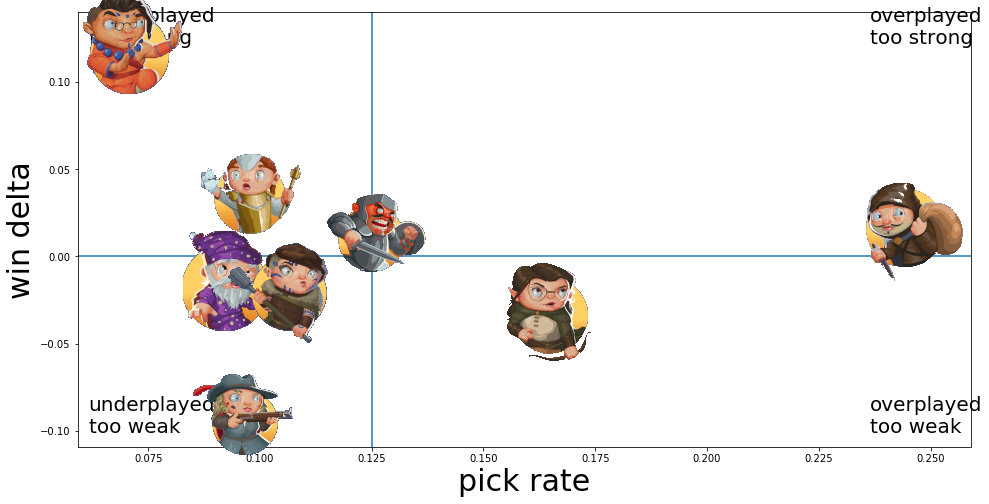

0.5138888888888888
0.46808510638297873
0.485981308411215
0.5141843971631206
0.5357142857142857
0.6219512195121951
0.4789915966386554
0.40909090909090906


In [9]:
# Pick rate, win delta.

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def getImage(path):
    return OffsetImage(plt.imread(path), zoom = 1)

# where dem image at boi?
paths = []

for c in chars:
    paths += ["images/square_" + full_name(c).lower() + ".png"]
    
games = db.completed_games
won_d = {}
played_d = {}
for c in chars:
    won_d[full_name(c)] = 0
    played_d[full_name(c)] = 0
for g in games.find():
    if not "p1c1" in g or not "p2c1" in g or len(g["Moves"]) < 2:
        malformed += 1
        continue
    winner = 2
    if g["p1c1_health"] + g["p1c2_health"] < 1:
        winner = 1
    if winner == 1:
        won_d[g["p1c1"]] += 1
        won_d[g["p1c2"]] += 1
    else:
        won_d[g["p2c1"]] += 1 
        won_d[g["p2c2"]] += 1
    played_d[g["p1c1"]] += 1
    played_d[g["p1c2"]] += 1
    played_d[g["p2c1"]] += 1
    played_d[g["p2c2"]] += 1
    
print(played_d)
print(won_d)
win_delta = []
pick_rate = []
for c in chars:
    win_delta += [(0.5 - won_d[full_name(c)] / played_d[full_name(c)])]
    pick_rate += [played_d[full_name(c)] / sum(played_d.values())]

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(pick_rate, win_delta)
for x0,y0,path in zip(pick_rate, win_delta,paths):
    ab = AnnotationBbox(getImage(path), (x0,y0), frameon=False, pad = 50)
    ax.add_artist(ab)
plt.axhline(y=0.0)
plt.axvline(x=0.125)
plt.xlabel('pick rate', fontsize=30)
plt.ylabel('win delta', fontsize=30)
plt.text(np.max(pick_rate)-0.01, np.max(win_delta), "overplayed\ntoo strong", fontsize=20)
plt.text(np.max(pick_rate)-0.01, np.min(win_delta)-0.01, "overplayed\ntoo weak", fontsize=20)
plt.text(np.min(pick_rate)-0.01, np.max(win_delta), "underplayed\ntoo strong", fontsize=20)
plt.text(np.min(pick_rate)-0.01, np.min(win_delta)-0.01, "underplayed\ntoo weak", fontsize=20)
plt.show()

for x in win_delta:
    print(x+0.5) 